In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import sys
sys.path.append("../../")

In [108]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pymc as pm 
import arviz as az

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import convert_aspect_to_cardinal_direction, encode_nuts_id, nuts_lvl_3_encoding
from src.modeling.utils import temporal_train_test_split
from src.modeling.bayesian_models import create_st_blr
from src.modeling.predictions import BinaryClassification

In [39]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [40]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)


In [41]:
# read in NUTS data
nuts_data = gpd.read_file(paths["nuts_data"])

### Data Cleaning & Preparation

In [42]:
training_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       2237 non-null   int64         
 1   date        2237 non-null   datetime64[ns]
 2   Pufferradi  1121 non-null   object        
 3   fire        2237 non-null   int64         
 4   year        2237 non-null   object        
 5   month       2237 non-null   object        
 6   day         2237 non-null   object        
 7   farmyard_d  2237 non-null   float64       
 8   hiking_ds   2237 non-null   float64       
 9   forest_ds   2237 non-null   float64       
 10  rail_dens   2237 non-null   float64       
 11  elevation   2237 non-null   float64       
 12  slope       2237 non-null   float64       
 13  aspect      2237 non-null   float64       
 14  foresttype  2199 non-null   float64       
 15  pop_dens    2237 non-null   float64       
 16  ffmc        2237

In [43]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

# create column with nuts id for level 3
nuts_austria_lvl3 = nuts_data.loc[(nuts_data['CNTR_CODE'] == "AT") & (nuts_data['LEVL_CODE'] == 3)]
nuts_austria_lvl3.to_crs(PROJECT_EPSG, inplace=True)
training_data = training_data.sjoin(nuts_austria_lvl3.loc[:, ["NUTS_ID", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 

# encode aspect 
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)

# encode NUTS_ID
training_data["nuts_id_encoded"] = training_data["NUTS_ID"].apply(encode_nuts_id, mapping=nuts_lvl_3_encoding)

# replace None values of forest type with class "low and no vegetation (6)"
training_data["forest_type"].fillna(6, inplace=True)

# transform type of forest_type to int
training_data["forest_type"] = training_data["forest_type"].astype(int)

c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Temporal train test split

In [91]:
X_train, X_test = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train["fire"], X_test["fire"]

### Feature Scaling

In [92]:
# Define the transformer
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
passthrough_columns = ['date', 'Pufferradi', 'fire', 'geometry', 'season', 'nuts_id_encoded', 'aspect_encoded', 'forest_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale)
    ],
    remainder='drop'
)


train_data_transformed = preprocessor.fit_transform(X_train)
test_data_transformed = preprocessor.transform(X_test)

X_train_features_to_scale = pd.DataFrame(train_data_transformed, columns=features_to_scale, index=X_train.index)
X_test_features_to_scale = pd.DataFrame(test_data_transformed, columns=features_to_scale, index=X_test.index)

X_train = pd.concat([X_train[passthrough_columns], X_train_features_to_scale], axis=1)
X_test = pd.concat([X_test[passthrough_columns], X_test_features_to_scale], axis=1)

### Modeling

In [93]:
coords = {"forest_type_classes": list(np.unique(training_data.forest_type)), 
          "aspect_classes": list(np.unique(training_data.aspect_encoded)), 
          "spatial_groups": list(np.unique(training_data.nuts_id_encoded)), 
          "temporal_groups": list(np.unique(training_data.season))}
print(coords)

{'forest_type_classes': [0, 1, 2, 3, 4, 5, 6], 'aspect_classes': [0, 1, 2, 3, 4, 5, 6, 7], 'spatial_groups': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 'temporal_groups': [0, 1, 2, 3]}


In [94]:
model = create_st_blr(X_train, y_train, coords, "nuts_id_encoded", "season")

In [97]:
with model:
    map_estimate=pm.find_MAP()
    step = pm.Metropolis()
    #idata=pm.sample(draws=10000, tune=5000, start=map_estimate, step=step, return_inferencedata=True)
    approx = pm.fit()
    idata = approx.sample()

Finished [100%]: Average Loss = 1,595.7


### Check Model 

c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\arviz\plots\traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'mu_b1'}>,
        <AxesSubplot: title={'center': 'mu_b1'}>],
       [<AxesSubplot: title={'center': 'mu_b2'}>,
        <AxesSubplot: title={'center': 'mu_b2'}>],
       [<AxesSubplot: title={'center': 'mu_b3'}>,
        <AxesSubplot: title={'center': 'mu_b3'}>],
       [<AxesSubplot: title={'center': 'mu_b4'}>,
        <AxesSubplot: title={'center': 'mu_b4'}>],
       [<AxesSubplot: title={'center': 'mu_b5'}>,
        <AxesSubplot: title={'center': 'mu_b5'}>],
       [<AxesSubplot: title={'center': 'mu_b6'}>,
        <AxesSubplot: title={'center': 'mu_b6'}>],
       [<AxesSubplot: title={'center': 'mu_b7'}>,
        <AxesSubplot: title={'center': 'mu_b7'}>],
       [<AxesSubplot: title={'center': 'mu_b8'}>,
        <AxesSubplot: title={'center': 'mu_b8'}>],
       [<AxesSubplot: title={'center': 'mu_b9'}>,
        <AxesSubplot: title={'center': 'mu_b9'}>],
       [<AxesSubplot: title={'center': 'mu_b10'}>,
        <AxesSubplot: title={'center': '

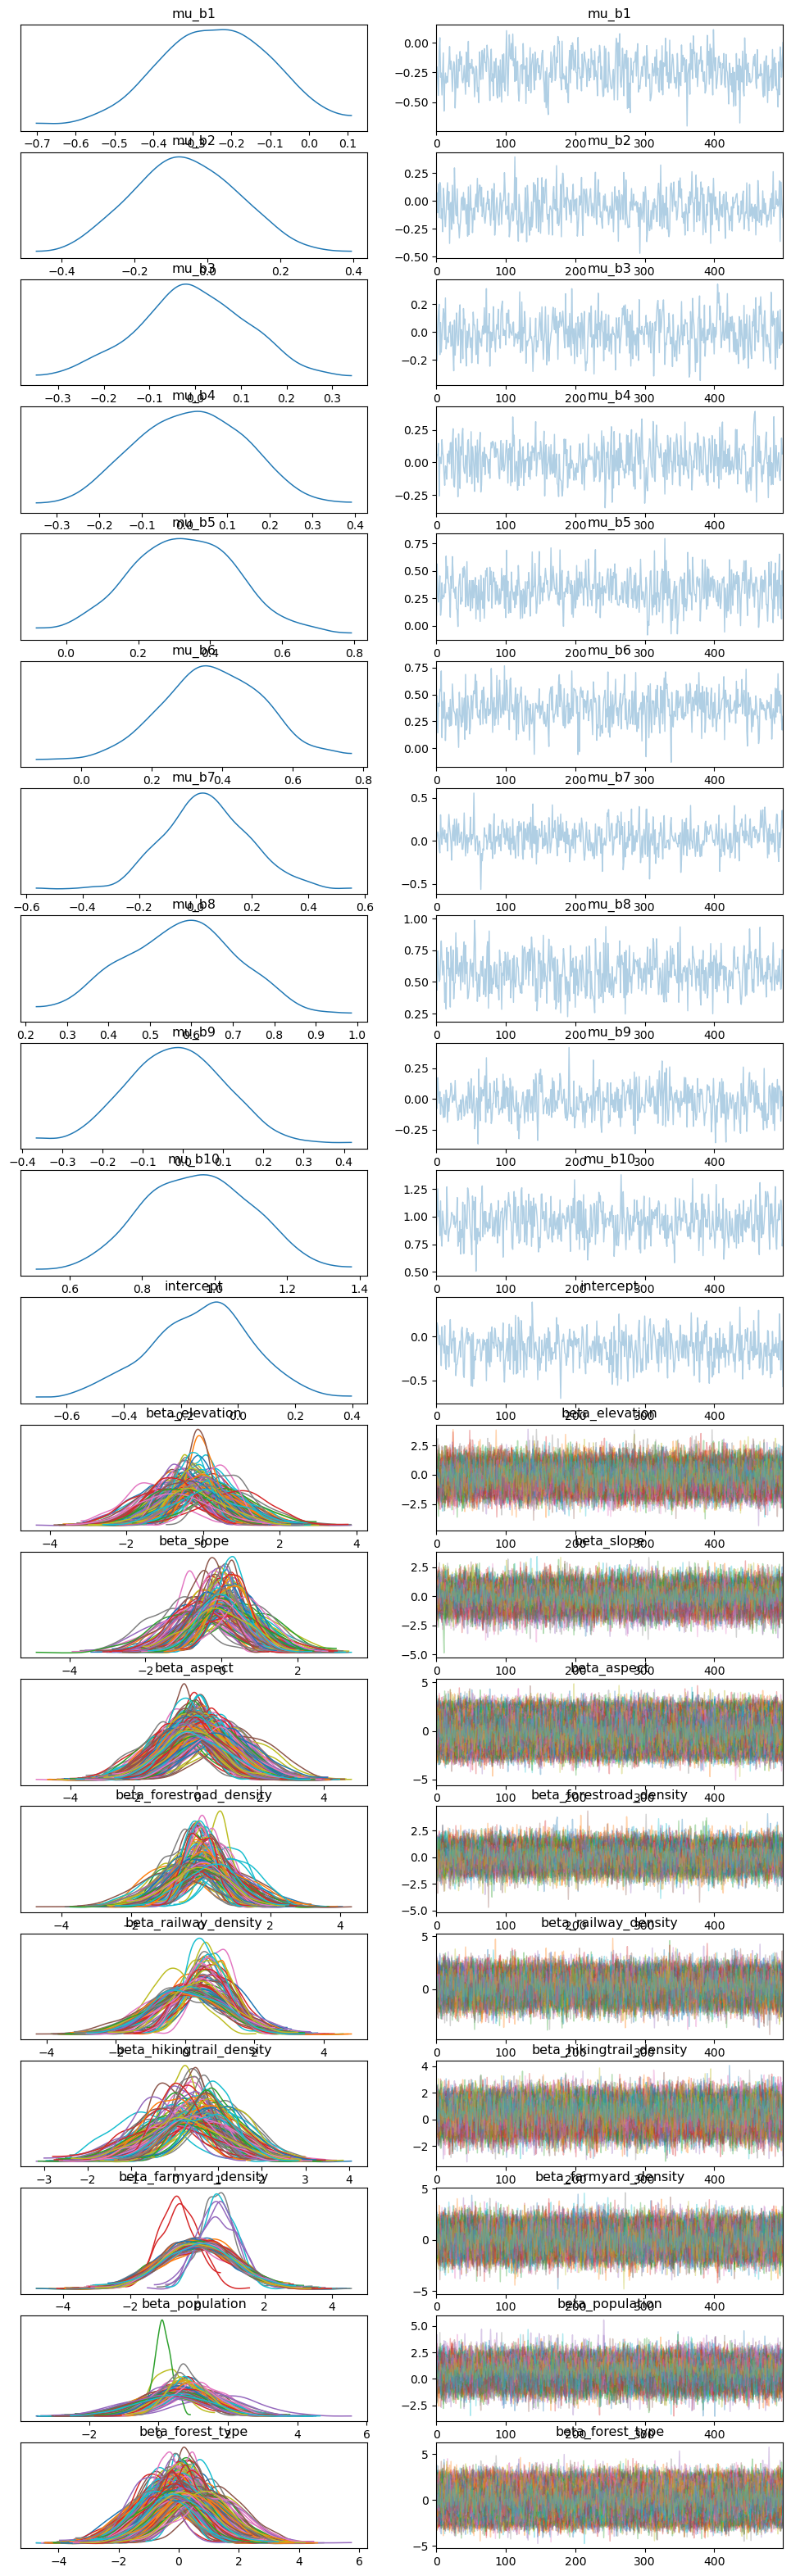

In [99]:
az.plot_trace(idata)

In [112]:
#az.plot_posterior(idata, var_names=["beta_elevation", "beta_ffmc", "beta_population"])

In [120]:
az.summary(idata, var_names=["beta_elevation", "beta_ffmc", "beta_population"])

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_elevation[0, 0]",-0.167,0.744,-1.690,1.163,0.032,0.024,543.0,472.0,NaN
"beta_elevation[0, 1]",0.108,0.759,-1.315,1.497,0.035,0.025,476.0,438.0,NaN
"beta_elevation[0, 2]",0.101,0.870,-1.476,1.812,0.040,0.030,467.0,407.0,NaN
"beta_elevation[0, 3]",0.006,1.020,-1.852,1.900,0.045,0.033,512.0,405.0,NaN
"beta_elevation[1, 0]",-0.690,0.772,-2.042,0.684,0.033,0.024,546.0,440.0,NaN
...,...,...,...,...,...,...,...,...,...
"beta_population[33, 3]",0.530,0.990,-1.234,2.442,0.045,0.034,479.0,497.0,NaN
"beta_population[34, 0]",1.029,0.724,-0.342,2.415,0.033,0.024,471.0,443.0,NaN
"beta_population[34, 1]",0.745,0.465,-0.174,1.497,0.022,0.015,458.0,474.0,NaN
"beta_population[34, 2]",0.814,0.616,-0.157,2.192,0.027,0.019,532.0,399.0,NaN


### Predictions on test set

In [121]:
y_dummy = [0 for i in y_test]
X_new = {
    "elevation": X_test.elevation,
    "slope": X_test.slope,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density,
    "railway_density": X_test.railway_density,
    "hikingtrail_density": X_test.hikingtrail_density,
    "farmyard_density": X_test.farmyard_density,
    "population": X_test.population_density,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "spatial_groups_idx": X_test.nuts_id_encoded,
    "temporal_groups_idx": X_test.season
    }

In [122]:
seed = 0
blr_prediction_obj = BinaryClassification(model, idata, X_new, seed, "y_pred", "p")

In [123]:

blr_prediction_obj.extend_trace()

Sampling: [y_pred]


ValueError: size does not match the broadcast shape of the parameters. (1565,), (1565,), (671,)
Apply node that caused the error: bernoulli_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x209D32F7CA0>), MakeVector{dtype='int64'}.0, TensorConstant{4}, p)
Toposort index: 15
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, (?,))]
Inputs shapes: ['No shapes', (1,), (), (671,)]
Inputs strides: ['No strides', (8,), (), (8,)]
Inputs values: [Generator(PCG64) at 0x209D32F7CA0, array([1565], dtype=int64), array(4, dtype=int64), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:

blr_preds = blr_prediction_obj.predict()